# Volatility/Frequency Arbitrage
## Steven Xu

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import quandl
import datetime as dt
quandl.ApiConfig.api_key = "9zu342hfxo1abY1pcd67"
ALPHAVANTAGE_API_KEY = "7GI26HCQ94CQ9SL0"
import seaborn as sns
sns.set()

Retrieve all the data using Bloomberg, Quandl, Yahoo Finance, Google Finance and WRDS as discussed in class.

I will provide guidance on how to have access to WRDS

Volatility signature:  
using the standard approach (squared root of variance of log returns adjusted for the sampling frequency: we assume 252 trading days per year) to compute volatility.

     1-1) Download intra-day and daily data for foreign currencies, S&P, DJA futures or ETFs  data using  either R, Python, C++, Java etc...  
     1-2) Compute the annualized volatility graph  with a sampling frequency from 1 day returns to 30 days returns       
     1-2-a) reproduce the graph at different time periods i.e. 2000 to 2007, and 2007 to 2014  
     1-2-b) compute the mean, the median, the 25% and 75% quantile for each frequency and plot the corresponding graphs  
     1-3) compute the volatility signature using intraday with annualized returns. the sampling frequency could range from seconds or minutes to few hours.        
     1-3-a) compute the mean, the median,  the 25% and 75% quantile for each frequency and plot the corresponding graphs  
Frequency Arbitrage:  
Implement the trading strategy for Frequency Arbitrage

In [2]:
def download_financial_data(name, source):
    df = data.DataReader(name, source,'2001-01-01', '2020-02-03')
    return df

In [3]:
df = pd.DataFrame()

df['^GSPC'] = download_financial_data('^GSPC', 'yahoo')['Adj Close']

In [4]:
df2 = df.copy()
idx =pd.date_range(min(df2.index), max(df2.index))
df2 = df2.reindex(idx, method = 'ffill')

# construct a dataset that interpolates between days to go to calendar days instead of trading days.

In [5]:
deltaT = ((df.index.shift(1,'B')-df.index).to_series().dt.days)

In [6]:
np.sqrt(deltaT)

Date
1 days    1.000000
1 days    1.000000
1 days    1.000000
3 days    1.732051
1 days    1.000000
            ...   
1 days    1.000000
1 days    1.000000
3 days    1.732051
1 days    1.000000
1 days    1.000000
Name: Date, Length: 4802, dtype: float64

In [7]:
a = df['^GSPC']/df['^GSPC'].shift(1) 
#this is the proper format for getting 1 day returns


In [8]:
# df['logreturn'] = np.log(df['^GSPC']/df['^GSPC'].shift(1) ) / np.sqrt(deltaT)

In [9]:
# np.std(df.logreturn)*np.sqrt(252)

In [10]:
stdevs = []
stdevs5 = []
stdevs2 = []
stdevs0007 = []
stdevs0714 = []
stdevs1420= []
means = []
medians =  []
q25 = []
q75 = []
freqs = np.arange(1,31,1)
today = dt.date.today()

past5 = dt.date(today.year-5, today.month,today.day)
past2 =  dt.date(today.year-2, today.month,today.day)
for i in freqs:
    
    
    #this code calculates log returns on each day counting from i trading days previous. It is smoother than the other method.
#     deltaT = ((df.index.shift(i,'B')-df.index).to_series().dt.days)
#     logret = np.log(df['^GSPC']/df['^GSPC'].shift(i) ) / np.sqrt(deltaT).values
    
#     #this code calculates a log return every i trading days. It has an up-and-down periodicity at around 10 days onward.
    dfi = df['^GSPC'][0::i]
    deltaT = (dfi.index.to_series().shift(-1)-dfi.index.to_series()) .dt.days
    logret = np.log(dfi/dfi.shift(1) )      / np.sqrt(deltaT).values
    
    stdevs.append(logret.std()*np.sqrt(252/i))
    stdevs5.append(logret.loc[past5:].std()*np.sqrt(252/i))
    stdevs2.append(logret.loc[past2:].std()*np.sqrt(252/i))
    stdevs0007.append(logret.loc['2000-01-01':'2006-12-31'].std()*np.sqrt(252/i))
    stdevs0714.append(logret.loc['2007-01-01':'2013-12-31'].std()*np.sqrt(252/i))
    stdevs1420.append(logret.loc['2014-01-01':'2020-12-31'].std()*np.sqrt(252/i))
    
    #the returns are also annualized 
    annualize = 252/i
#     annualize = 1
    means.append(logret.mean()*annualize)
    medians.append(logret.median()*annualize)
    q25.append(logret.quantile(q=.25)*annualize)
    q75.append(logret.quantile(q=.75)*annualize)
    

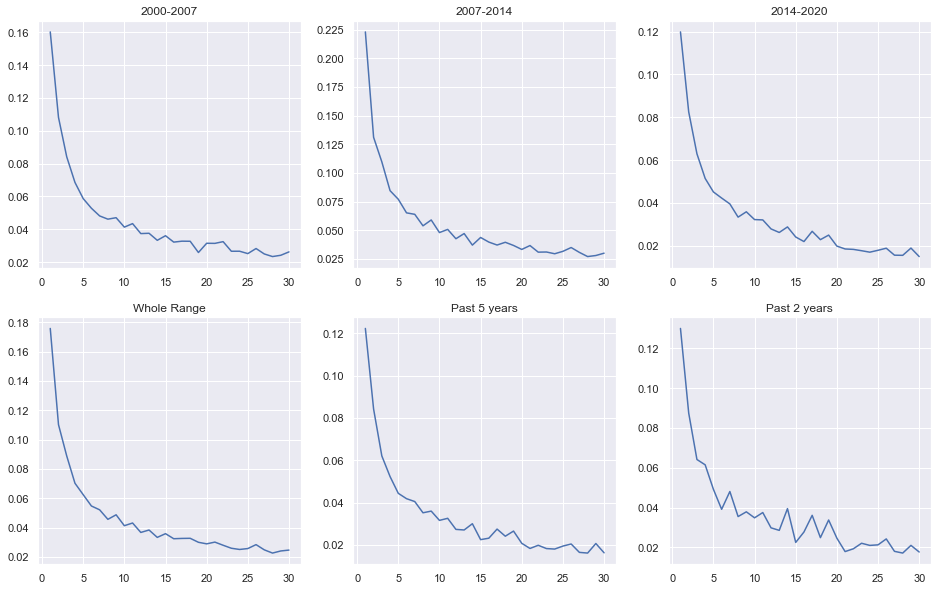

In [11]:
# plt.plot(freqs, stdevs)
# plt.plot(freqs,stdevs5)
# plt.plot(freqs, stdevs2)
fig, ax = plt.subplots(2,3, figsize = (16,10))

ax[0,0].plot(freqs, stdevs0007)
ax[0,0].set_title('2000-2007')
ax[0,1].plot(freqs, stdevs0714)
ax[0,1].set_title('2007-2014')
ax[0,2].plot(freqs, stdevs1420)
ax[0,2].set_title('2014-2020')
ax[1,0].plot(freqs, stdevs)
ax[1,0].set_title('Whole Range')
ax[1,1].plot(freqs, stdevs5)
ax[1,1].set_title('Past 5 years')
ax[1,2].plot(freqs, stdevs2)
ax[1,2].set_title('Past 2 years');
# plt.plot(freqs,stdevs0714)
# plt.plot(freqs, stdevs1420)
# plt.xlim(1,30)

Text(0.5, 1.0, 'Mean, Median, and Q25 and Q75')

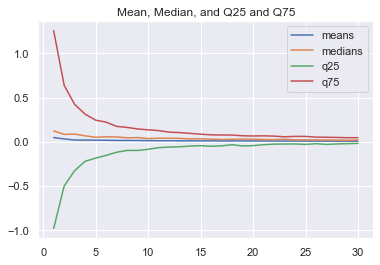

In [12]:
plt.plot(freqs, means)
plt.plot(freqs, medians)
plt.plot(freqs, q25)
plt.plot(freqs, q75)
plt.legend(['means','medians', 'q25', 'q75'])
plt.title("Mean, Median, and Q25 and Q75")

In [13]:
s = dt.datetime(2020,1,3,9,30)
print(s)
intraday = data.DataReader("^GSPC", "av-intraday", start = dt.datetime(2020,3,3,9,30), 
                           end = dt.datetime(2020,3,4,16,0),
                           api_key = ALPHAVANTAGE_API_KEY)['close']
#am only using AlphaVantage bc data is free and I don't know the SQL to query WRDS yet. limitation is then minute data

2020-01-03 09:30:00


In [14]:
intraday.index = pd.to_datetime(intraday.index)

In [15]:
freqs = np.arange(1,121,1)
stdevs = []
means = []
medians = []
q25 = []
q75 = []
for i in freqs:
    
    
    #this code calculates log returns on each day counting from i trading days previous. It is smoother than the other method.
#     deltaT = ((df.index.shift(i,'B')-df.index).to_series().dt.days)
#     logret = np.log(df['^GSPC']/df['^GSPC'].shift(i) ) / np.sqrt(deltaT).values
    
#     #this code calculates a log return every i trading days. It has an up-and-down periodicity at around 10 days onward.
    dfi = intraday[0::i]
    deltaT = (dfi.index.to_series().shift(-1)-dfi.index.to_series()).dt.seconds/86400
    logret = np.log(dfi/dfi.shift(1) )      / np.sqrt(deltaT).values
    
    stdevs.append(logret.std()*np.sqrt(252/i))

    
    #the returns are also annualized 
    annualize = 252/i
#     annualize = 1
    means.append(logret.mean()*annualize)
    medians.append(logret.median()*annualize)
    q25.append(logret.quantile(q=.25)*annualize)
    q75.append(logret.quantile(q=.75)*annualize)
    

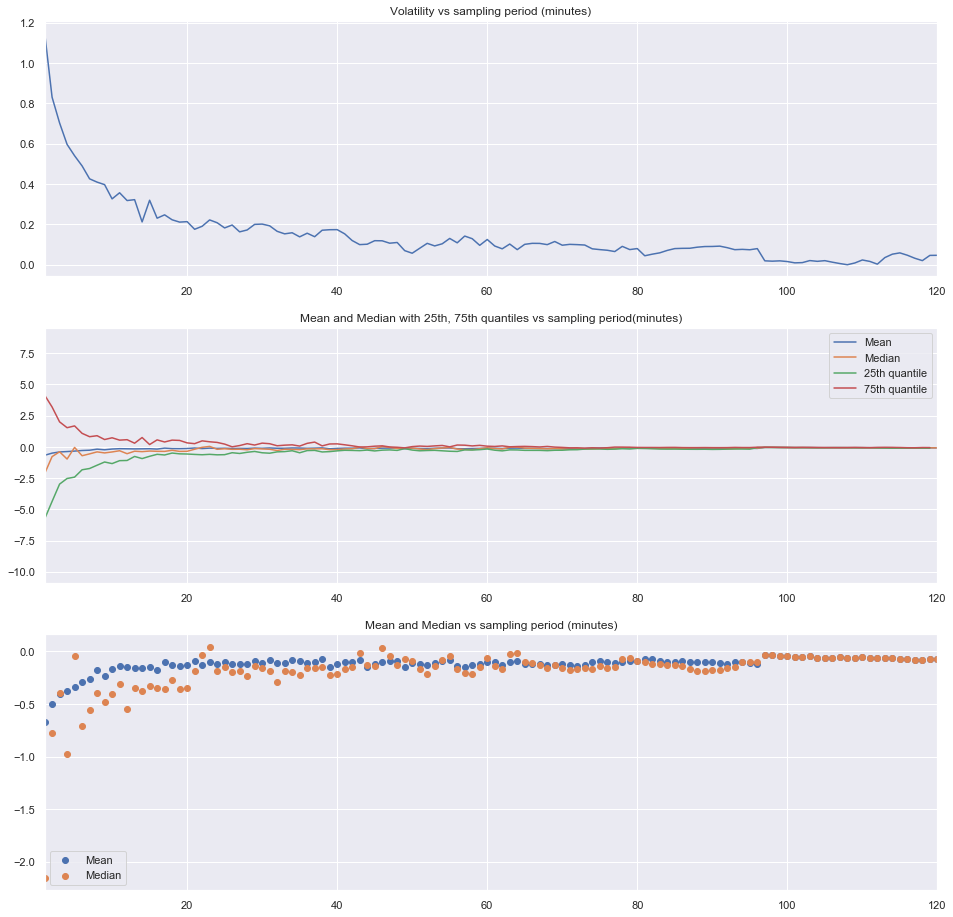

In [16]:
fig, ax = plt.subplots(3, figsize = (16,16))
ax[0].plot(freqs, stdevs)
ax[0].set_title('Volatility vs sampling period (minutes)')
ax[1].plot(freqs, means)
ax[1].plot(freqs, medians)
ax[1].plot(q25)
ax[1].plot(q75)
ax[1].set_title("Mean and Median with 25th, 75th quantiles vs sampling period(minutes)")
ax[1].legend(['Mean','Median','25th quantile', '75th quantile'])
ax[2].scatter(freqs, means)
ax[2].scatter(freqs, medians)
ax[2].set_title('Mean and Median vs sampling period (minutes)')
ax[2].legend(['Mean','Median'])

for a in ax:
    a.set_xlim(freqs[0], freqs[-1])

$\alpha (\frac 1 {S_{t,j}} - \frac 1 {S_{t,i}})$ is essentially being short weekly and long daily.

In [17]:
mondays = df.groupby(pd.Grouper(freq = 'W-MON')).nth(-1).index
tuesdays = df.groupby(pd.Grouper(freq = 'W-TUE')).nth(-1).index
wednesdays = df.groupby(pd.Grouper(freq = 'W-WED')).nth(-1).index
thursdays = df.groupby(pd.Grouper(freq = 'W-THU')).nth(-1).index
fridays = df.groupby(pd.Grouper(freq = 'W-FRI')).nth(-1).index

#for some reason, Wednesdays give the best long-term alpha.

In [18]:
alpha = 100
exposure = 0
cash = 0
wealth = cash

daywealth = []
dayexposure = []
weekwealth = []
weekexposure = []
cashs = []
wealths1 = []
Sdold = 0
firstday = wednesdays
for x in range(len(firstday)-1):
    week = df[firstday[x]:firstday[x+1]]
    S1 = week.iloc[0]['^GSPC']
    for day in week.iterrows():
        
        
        Sd = day[1]['^GSPC']
       
        wealth += exposure*(Sd-Sdold)
        
#         cash -= alpha
        exposure = alpha * (1/Sd-1/S1)        
        Sdold = Sd
        
        dayexposure.append(exposure)
    weekexposure.append(exposure)
    cashs.append(cash)
    wealths1.append(wealth)
        

In [19]:
alpha = 100
cash = 0
wealth = cash
wealths = []
weekleg = 0
dayleg = 0
weekly = []
daily = []
ex = []
firstday = wednesdays
for x in range(len(firstday)-1):
    week = df[firstday[x]:firstday[x+1]]
    S1 = week.iloc[0]['^GSPC']
    
    try:
        cash += weekleg*S1 #buyback to rebalance
    except:
        print('Not yet existent')
        continue
        
    cash += alpha
    weekleg = -alpha/S1
    
    for day in week.iterrows():
        Sd = day[1]['^GSPC']
        try:
            cash += dayleg*Sd
        except:
            print('Not yet existent')
            continue
        cash -= alpha
        dayleg = alpha/Sd
        ex.append(dayleg + weekleg)
        daily.append(dayleg)
    weekly.append(weekleg)
    wealth = cash + (weekleg + dayleg)*week.iloc[-1]['^GSPC']
    wealths.append(wealth)

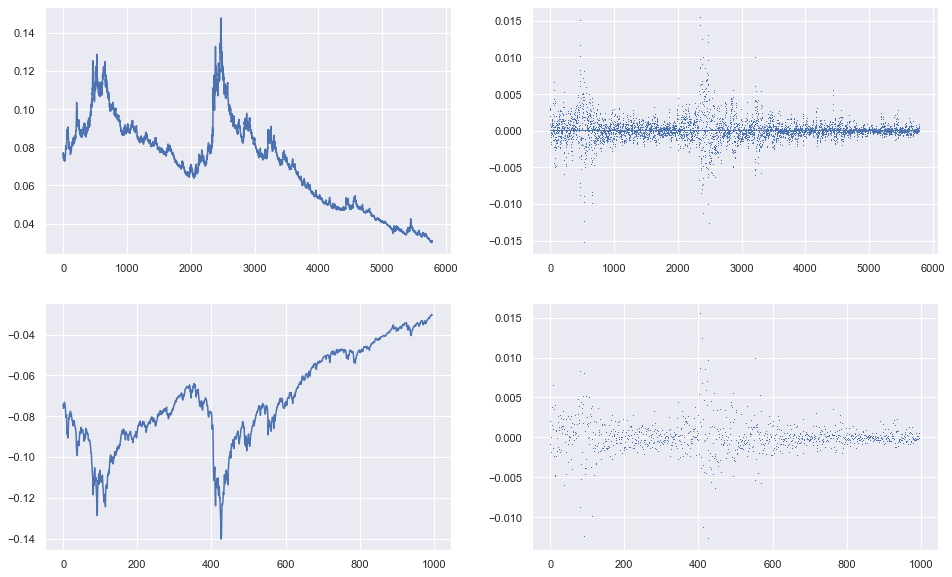

In [20]:
fig, ax = plt.subplots(2,2, figsize = (16,10))
ax[0,0].plot(daily)
ax[1,0].plot(weekly)
ax[0,1].plot(dayexposure, marker = ',', linewidth = 0)
ax[1,1].plot(weekexposure, marker = ',', linewidth = 0)

In [21]:
week =df[mondays[x]:mondays[x+1]]

In [22]:
week.iloc[0]['^GSPC']

3248.919921875

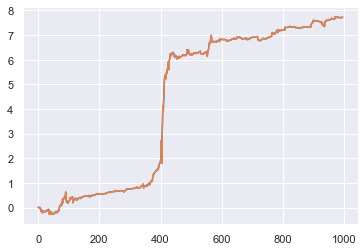

In [23]:
plt.plot(wealths)

plt.plot(wealths1)

Empirically, we can see that the exposure $ \alpha(\frac{1}{S_{i,j}} - \frac 1 {S_{i,1}})$ is identical to holding both a long and short position.

Portfolio consists of: short stock, rebalanced weekly. Long stock, rebalanced daily.

In week i, day 1, we get $\alpha$ by selling $\frac{\alpha}{S_{i,1}}$ shares of stock. We reinvest this and take a long position of $\alpha$ by buying $\frac\alpha{S_{i,1}} $shares of stock at $S_{i,j}$. Every day we rebalance ensuring that $\alpha$ is invested in the daily-rebalanced position. 

Following this strategy on day 2 of week i our long daily-rebalanced position will be $\frac\alpha{S_{i,2}}$ and our short weekly rebalanced position will remain $\frac{\alpha}{S_{i,1}}$. The effective number of shares we hold is $ \frac\alpha{S_{i,2}} - \frac{\alpha}{S_{i,1}} =  \alpha(\frac{1}{S_{i,2}} - \frac 1 {S_{i,1}})$

Every day j our gain is  $E_{i, j-1}(S_{i,j} - S_{i, j-1})$, where E is some description of our exposure. 

Define an option with payoff $-ln(S_T)$. 

The daily leg is 'long' some strip of these options $C_T$ while the weekly leg is 'short' some strip of these options, again $C_T$. We delta-hedge both positions according to their frequency:

$\pi_A = C_T - \Delta_d S_{i,j} $  
$\pi_B = C_T - \Delta_w S_{i,1} $


Change in time becomes:   
$\partial \pi_A = (\theta +\frac 1 2 \Gamma S^2\sigma_a^2)dt$  
$\partial \pi_B = (\theta +\frac 1 2 \Gamma S^2\sigma_b^2)dt$  

Netting these positions we get:

$\pi = \pi_A-\pi_B = \Delta_w S_{i,1} - \Delta_d S_{i,j}$  
$\partial \pi = \partial \pi_A - \partial \pi_B = \frac 1 2 \Gamma S^2 (\sigma_a^2 - \sigma_b^2) dt$  

Consider our option O with payoff $O = -ln(S_T)$. Assume our stock follows a geometric brownian motion. I believe this is a variance swap. Then:  

$E[O] = E[-ln(S_T) = -ln(S_0)-(\mu - \frac{\sigma^2}2)t$  
$\Delta = \frac{\partial O}{\partial S_0} = \frac{-1}{S_0}$  
$\Gamma = \frac 1 {S_0^2}$

The ultimate goal is to benefit from the spread in vol. Using our new option our portfolio becomes:  
$\pi_A = O_T - \Delta_d S$  
$\pi_B = O_T - \Delta_d S$  

$\partial \pi_A = \frac{\partial O}{\partial t}\partial t - \frac 1 2 \Gamma (\delta S_t)^2 = \theta - \frac 1 2 \Gamma \sigma^2 S_T^2 dt = \theta - \frac 1 2 \sigma_A^2 dt$

Thus:

$\partial \pi = \partial \pi_A - \partial \pi_B = \frac 1 2 (\sigma_B^2 - \sigma_A^2) dt$  
(In English, every day our portfolio value changes by the difference between the larger and smaller volatilities)

We let $\sigma_B$ be daily vol and $\sigma_A$ be weekly vol. Then:  

$\pi_A = O_T - \Delta_w S_d$  
$\pi_B = O_T - \Delta_d S_d$  

for a portfolio consisting of:  
$\pi = \pi_A-\pi_B=-\Delta_w S_d + \Delta_d S_d $  
where:  
$S_d = S_{i,j}$
$\Delta_d = \frac 1 {S_{i,j}}$ and $\Delta_w = \frac 1 {S_{i,1}}$

Our option positions cancel each other out, leaving only varying levels of exposure to a daily stock.

So:  
$\pi = S_d( \frac 1 {S_{i,j}} - \frac 1 {S_{i,1}})$

Our per dollar invested exposure is:  
$ \frac 1 {S_{i,j}} - \frac 1 {S_{i,1}}$

C:\Users\steve\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


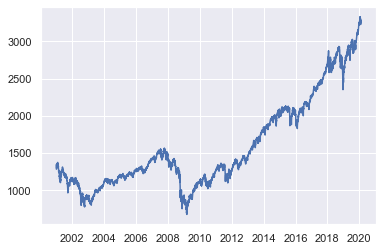

In [24]:
plt.plot(df['^GSPC'])

In [25]:
alpha/df['^GSPC'][0]*df['^GSPC'][-1]

256.9677493981478

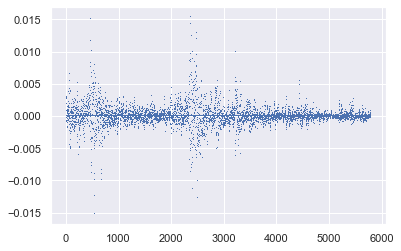

In [26]:
plt.plot(ex, marker=',', linewidth = 0)
# plt.plot(dayexposure, marker = ',', linewidth = 0)

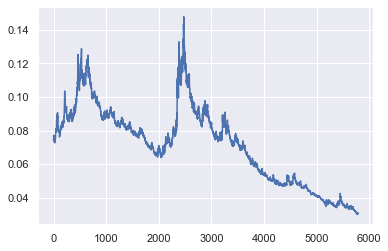

In [27]:
plt.plot(daily)

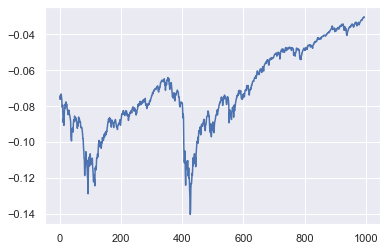

In [28]:
plt.plot(weekly)

The cell below shows how much wealth is gained by conducting this trade.

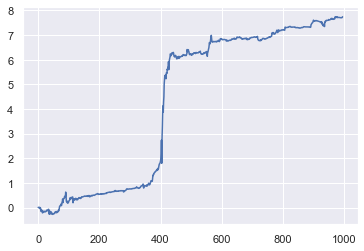

In [29]:
plt.plot(wealths)

In [30]:
intraday.index

DatetimeIndex(['2020-03-03 09:31:00', '2020-03-03 09:32:00',
               '2020-03-03 09:33:00', '2020-03-03 09:34:00',
               '2020-03-03 09:35:00', '2020-03-03 09:36:00',
               '2020-03-03 09:37:00', '2020-03-03 09:38:00',
               '2020-03-03 09:39:00', '2020-03-03 09:40:00',
               ...
               '2020-03-03 15:51:00', '2020-03-03 15:52:00',
               '2020-03-03 15:53:00', '2020-03-03 15:54:00',
               '2020-03-03 15:55:00', '2020-03-03 15:56:00',
               '2020-03-03 15:57:00', '2020-03-03 15:58:00',
               '2020-03-03 15:59:00', '2020-03-03 16:00:00'],
              dtype='datetime64[ns]', length=388, freq=None)

In [31]:
.5*(stdevs[0]**2-stdevs[6]**2)*252*20
#an attempt at approximating what total gain should be if  the equation delta pi \propto (sigma_a^2 - sigma_b^2) dt holds. 
#Does not appear to be close to implemented strategy in the slightest.

2890.367938451605